# 7 Modeling<a id='5_Modeling'></a>

## 7.1 Contents<a id='7.1_Contents'></a>
* [7 Modeling](#7_Modeling)
  * [7.1 Contents](#7.1_Contents)
  * [7.2 Introduction](#7.2_Introduction)
  * [7.3 Imports](#7.3_Imports)
  * [7.4 Load Model](#7.4_Load_Model)
  * [7.5 Load Data](#7.5_Load_Data)
  * [7.6 Refit Model On All Available Data (excluding Florida Hospital)](#7.6_Refit_Model_On_All_Available_Data_(excluding_Florida_Hospital))
  * [7.7 Calculate Expected Price From The Model](#7.7_Calculate_Expected_Procedure_Price_Using_Florida_Hospital_From_The_Model)
  * [7.8 Random Florida Hospital](#7.8_Random_Florida_Hospital_In_Insurance_Market_Context)
    * [7.8.1 Procedure price](#7.8.1_Procedure_price)
    * [7.8.2 Infection Ratings](#7.8.2_Infection_Ratings)
    * [7.8.3 Hospitals per 100k](#7.8.3_Hospitals_per_100k)
    * [7.8.4 Discharges per 100k](#7.8.4_Discharges_per_100k)
    * [7.8.5 Discharge Ratio](#7.8.5_Discharge_Ratio)
    * [7.8.6 Bed Ratio](#7.8.6_Bed_Ratio)
    * [7.8.7 Interns/Residents](#7.8.7_Interns_Residents)
    * [7.8.8 Hospital Days](#7.8.8_Hospital_Days)
  * [7.9 Modeling scenarios](#7.9_Modeling_scenarios)
    * [7.9.1 Scenario 1](#7.9.1_Scenario_1)
    * [7.9.2 Scenario 2](#7.9.2_Scenario_2)
    * [7.9.3 Scenario 3](#7.9.3_Scenario_3)
    * [7.9.4 Scenario 4](#7.9.4_Scenario_4)
  * [7.10 Summary](#7.10_Summary)
  * [7.11 Further work](#7.11_Further_work)


## 7.2 Introduction<a id='7.2_Introduction'></a>

In this notebook, we now take our model for pricing and leverage it to gain some insights into what price of a random Florida hospital might actually support as well as explore the sensitivity of changes to various resort parameters. Note that this relies on the implicit assumption that all other resorts are largely setting prices based on how much people value certain facilities. 
In addition, from our previous notebook we can see that our accuracy from this model is not the highest, at 79%, so please take this analysis with a grain of salt. I will address this in the conclusion.

## 7.3 Imports<a id='7.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

## 7.4 Load Model<a id='7.4_Load_Model'></a>

In [2]:
expected_model_version = 1
model_path = '../models/procedure_pricing_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model_test = pickle.load(f)
    if model_test.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model_test.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

## 7.5 Load Data<a id='7.5_Load_Data'></a>

In [3]:
path = 'data'
obj = os.scandir(path)
l = [entry for entry in obj]
df_dict = {}

for entry in l:
    p = entry.name[0:-8]
    df_dict[p] = pd.read_parquet('data/'+entry.name, engine='pyarrow')

# This is the same procedure we used in the previous notebook
procedure = 'CPT58150'
data = df_dict[procedure]
data= pd.get_dummies(data, columns=['Rural Versus Urban'], drop_first= True)

Lets pick a random Florida Hospital given it has the most hospitals within our list of procedures.

In [4]:
flordia_hospital = data[data['ccn']== 100168]

In [5]:
flordia_hospital.T

,4
ccn,100168
State Code,FL
PSI_03,2.915921
PSI_06,0.197895
PSI_08,0.062805
PSI_09,3.227263
PSI_10,3.064857
PSI_11,10.679905
PSI_12,5.43422
PSI_13,5.74758


## 7.6 Refit Model On All Available Data (excluding Florida Hospital)<a id='7.6_Refit_Model_On_All_Available_Data_(excluding_Florida_Hospital)'></a>

This next step requires some careful thought. We want to refit the model using all available data. We are going to exclude one Florida Hospital for our analysis, taking on the hospital as if it is our own. Let us ignore that hospital and recreate our model. 

In [6]:
X = data.loc[data['ccn'] != 100168, model_test.X_columns]
y = data.loc[data['ccn'] != 100168, 'negotiated_rates_median']

In [7]:
model = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators= 250,
    min_samples_split= 10,
    min_samples_leaf= 5,
    max_features='sqrt',
    max_depth= 80,
    bootstrap= True, 
    random_state = 42))


In [8]:
model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=80, max_features='sqrt',
                                       min_samples_leaf=5, min_samples_split=10,
                                       n_estimators=250, random_state=42))])

In [9]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [10]:
cv_results['test_score']

array([-260.47007905, -284.00863701, -240.44700675, -292.6516456 ,
       -255.54335469])

In [11]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(266.62414461980586, 19.107853663706493)

## 7.7 Calculate Expected Procedure Price Using Florida Hospital From The Model<a id='7.7_Calculate_Expected_Procedure_Price_Using_Florida_Hospital_From_The_Model'></a>

In [12]:
X_bm = data.loc[data['ccn'] == 100168, model_test.X_columns]
y_bm = data.loc[data['ccn'] == 100168, 'negotiated_rates_median']

In [13]:
bm_pred = model.predict(X_bm).item()

In [14]:
y_bm = y_bm.values.item()

In [15]:
print(f'Florida Hospital modeled price is ${bm_pred:.2f}, actual price is ${y_bm:.2f}.')
print(f'Even with the expected mean absolute error of ${mae_mean:.2f}.')

Florida Hospital modeled price is $1249.75, actual price is $1205.16.
Even with the expected mean absolute error of $266.62.


Even with the large error, there is possibility to increase the price or reimbursement for the hospital for this procedure.

## 7.8 Random Florida Hospital In Insurance Market Context<a id='5.8_Random_Florida_Hospital_In_Insurance_Market_Context'></a>

Features that came up as important in the modeling included:
* PSI_15
* HAI_2_SIR
* hospitals_per_100kcapita
* discharges_per_100kcapita
* bed_ratio
* discharge_ratio
* Number of Interns and Residents (FTE)

Some of these features are within the hospitals control, others are not. For example, PSI and HAI scores are easier to control and our interest for this analysis. The other metrics are more demand metrics and hospitals/discharges per 100k capita are state statistic, which hospitals have little agency to control.

In [16]:
def plot_compare(feat_name, description, state=None, figsize=(10, 5)):
    """Graphically compare distributions of features."""
    
    plt.subplots(figsize=figsize)
    if state is None:
        data_x = data[feat_name]
    else:
        data_x = data.loc[data['State Code'] == state, feat_name]
    data_x = data_x[np.isfinite(data_x)]
    plt.hist(data_x, bins=30)
    plt.axvline(x=flordia_hospital[feat_name].values, c='r', ls='--', alpha=0.8, label='Florida Hospital')
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for hospitals')
    plt.legend()

### 7.8.1 Procedure price<a id='7.8.1_Procedure_price'></a>

Look at where Florida Hospital sits overall amongst all resorts for price on this procedure and for just other hospitals in Florida.

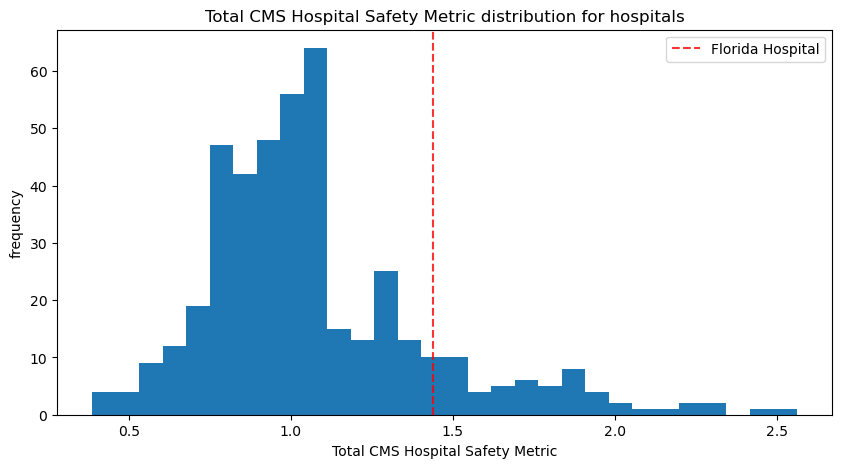

In [17]:
plot_compare('PSI_15', 'Total CMS Hospital Safety Metric')

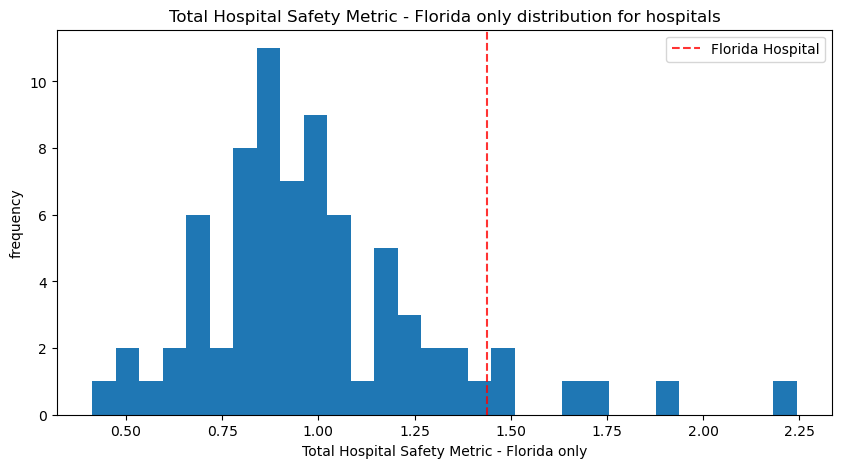

In [18]:
plot_compare('PSI_15', 'Total Hospital Safety Metric - Florida only', state='FL')

### 7.8.2 Infection Ratings<a id='7.8.2_Infection_Ratings'></a>

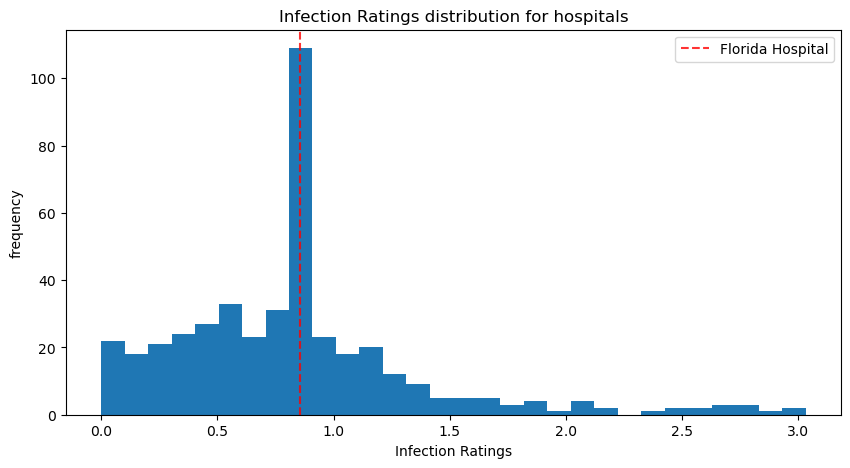

In [19]:
plot_compare('HAI_2_SIR', 'Infection Ratings')

Infection rating is right near the mode of values.

### 7.8.3 Hospitals per 100k<a id='7.8.3_Hospitals_per_100k'></a>

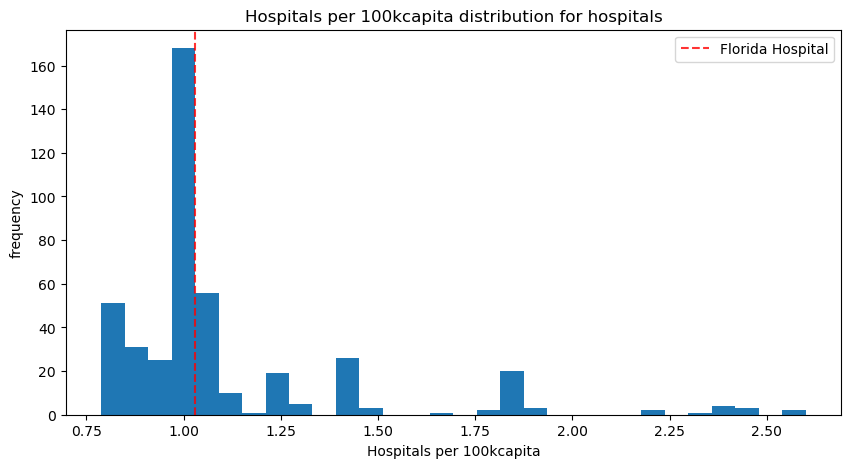

In [20]:
plot_compare('hospitals_per_100kcapita', 'Hospitals per 100kcapita')

Not surprising that our hospital lies with the mode here seeing that Florida hospitals are the most within our dataset and this is a state feature.

### 7.8.4 Discharges per 100k <a id='7.8.4_Discharges_per_100k'></a>

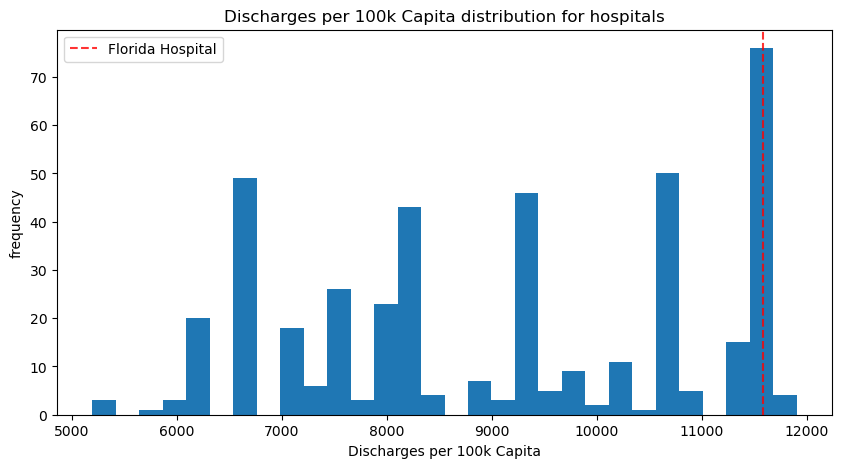

In [21]:
plot_compare('discharges_per_100kcapita', 'Discharges per 100k Capita')

Just like the above feature, not surprising that our hospital lies with the mode here seeing that Florida hospitals are the most within our dataset and this is a state feature.

### 7.8.5 Discharge Ratio<a id='7.8.5_Discharge_Ratio'></a>

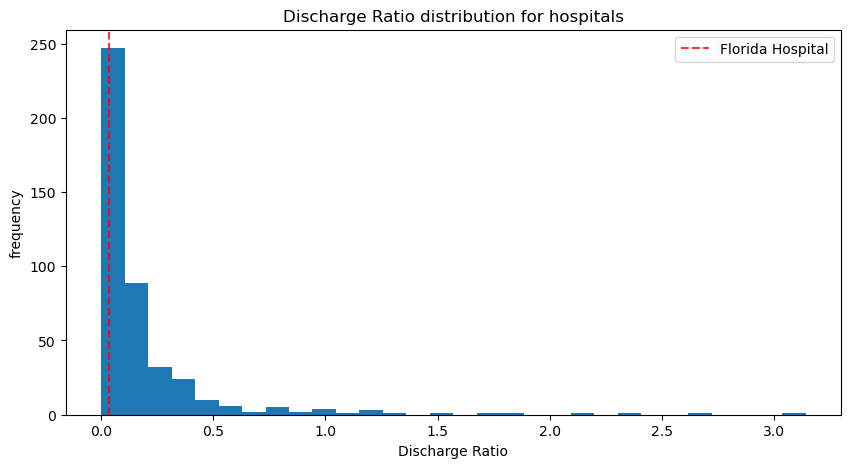

In [22]:
plot_compare('discharge_ratio', 'Discharge Ratio')

Since our hospital is in a large/populous state- this ratio is going to be small.

### 7.8.6 Bed Ratio<a id='7.8.6_Bed_Ratio'></a>

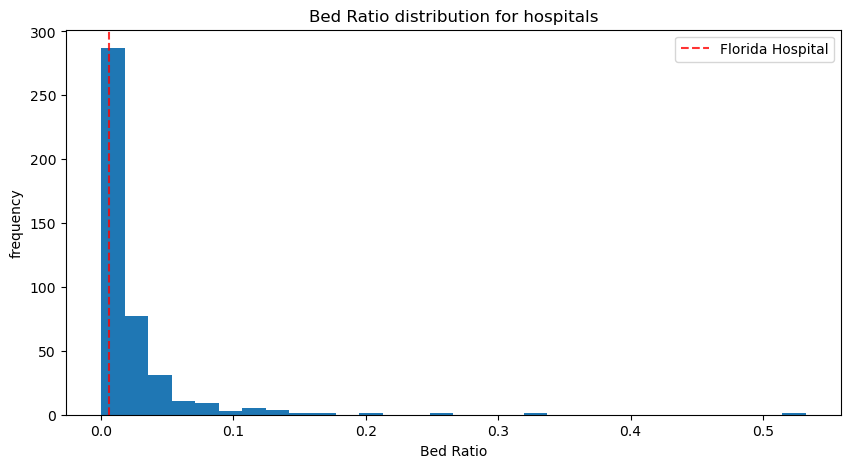

In [23]:
plot_compare('bed_ratio', 'Bed Ratio')

This is the same as the previous feature. Florida has numerous hospitals, so it is going to have a low bed ratio.

### 7.8.7 Interns/Residents<a id='7.8.7_Interns_Residents'></a>

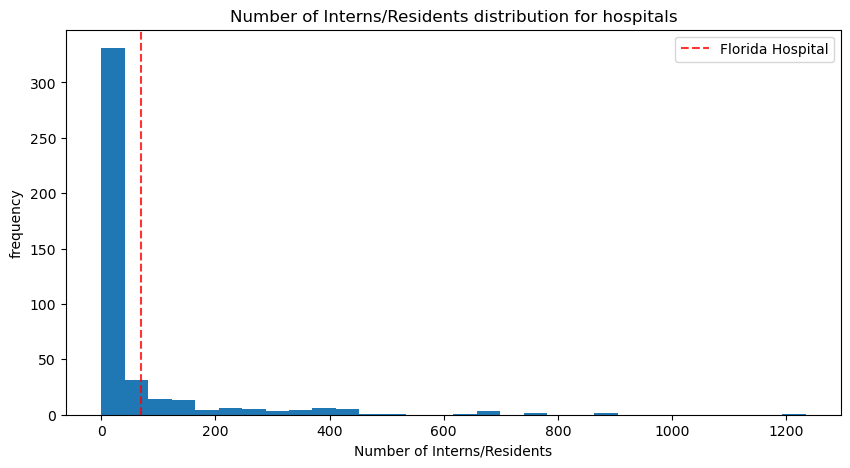

In [24]:
plot_compare('Number of Interns and Residents (FTE)', 'Number of Interns/Residents')

Our Random Florida Hospital seems to have at least some interns/residents. This is something that our hospital could improve.

### 7.8.8 Hospital Days<a id='7.8.8_Hospital_Days'></a>

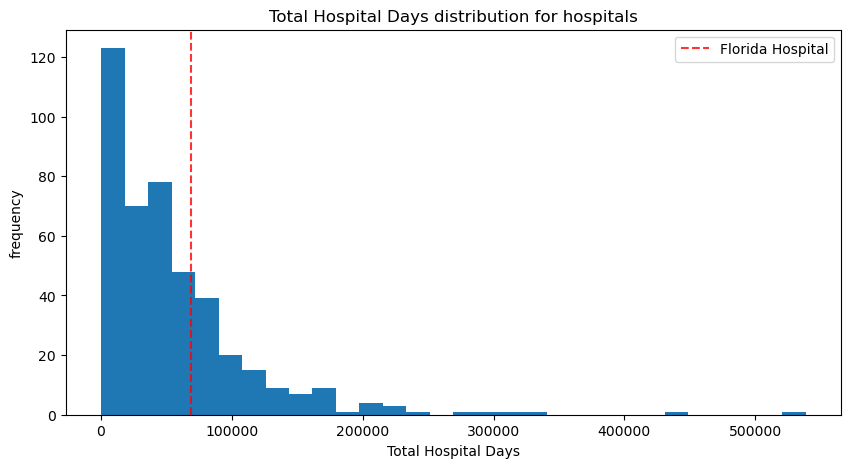

In [25]:
plot_compare('Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds', 'Total Hospital Days')

Our hospital has decent demand given its hospital days. This is harder to improve without acquiring more facilities or acquiring other hospitals in the area. This is a demand statistic.

## 7.9 Modeling scenarios<a id='7.9_Modeling_scenarios'></a>

Lets run through some scenarios that might be feasible for the hospital to accomplish to increase its price.

The possible options:
1. Increasing PSI 15 by a certain percentage or increase HAI 2 SIR by a certain percentage
2. Increase Demand by certain percentage by acquiring another hospital, either through discharge ratio/hospital days
3. Increase Number of Interns/Residents
4. Increase both PSI 15 and HAI 2 by a certain percentage

In [26]:
all_feats = ['PSI_15', 'HAI_2_SIR', 'Number of Interns and Residents (FTE)', 'bed_ratio', 
             'discharge_ratio', 'Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds']
flordia_hospital[all_feats]

,PSI_15,HAI_2_SIR,Number of Interns and Residents (FTE),bed_ratio,discharge_ratio,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds
4,1.438312,0.855,69.78,0.006489,0.037681,69105.32967


In [27]:
def predict_increase(features, deltas):
    bm2 = X_bm.copy()
    for f, d in zip(features, deltas):
        bm2[f] *= (1 + d)
    return model.predict(bm2).item() - model.predict(X_bm).item()

### 7.9.1 Scenario 1<a id='7.9.1_Scenario_1'></a>

I believe it is reasonable to increase these metrics from 10-40%. Let us take a look at these values.

In [28]:
deltas = [i * 0.1 for i in range(1, 5)]
price_deltas_psi = [predict_increase(['PSI_15'], [delta]) for delta in deltas]
price_deltas_sir = [predict_increase(['HAI_2_SIR'], [delta]) for delta in deltas]

In [29]:
price_deltas_psi

[0.0, 0.0, 3.949752761904847, 6.010933039682641]

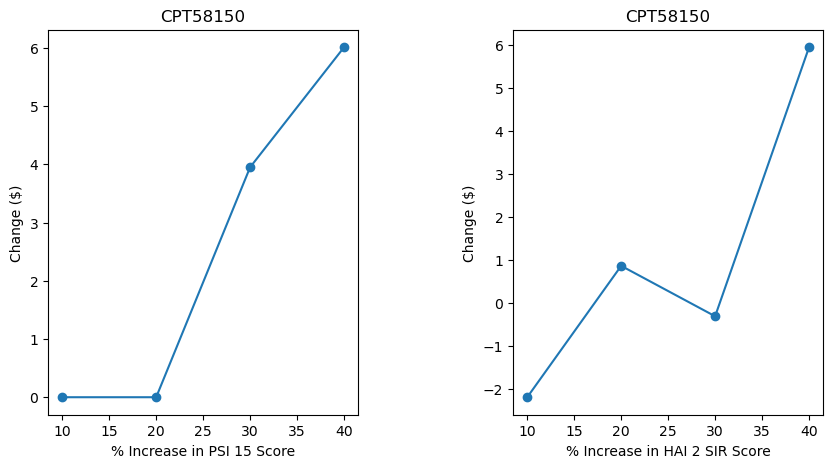

In [30]:
perc_change = [perc*100 for perc in deltas] #1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(perc_change, price_deltas_psi, 'o-')
ax[0].set(xlabel='% Increase in PSI 15 Score', ylabel='Change ($)', title=procedure)
ax[1].plot(perc_change, price_deltas_sir, 'o-')
ax[1].set(xlabel='% Increase in HAI 2 SIR Score', ylabel='Change ($)', title=procedure);

It seems like we would need to increase PSI by at least 30% based on this model, which may be difficult, to see a price increase. HAI 2 we would need to increase by 20% or 40 %. Later we will try our model with both increasing.

### 7.9.2 Scenario 2<a id='7.9.2_Scenario_2'></a>

In this Scenario we are looking at demand metrics that are cost intensive for the hospital and hard for them to control given the nature of medicine.

In [31]:
hosp_days_increase = [predict_increase(['Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds'], [delta]) for delta in deltas]
discharge_ratio_increase = [predict_increase(['discharge_ratio'], [delta]) for delta in deltas]

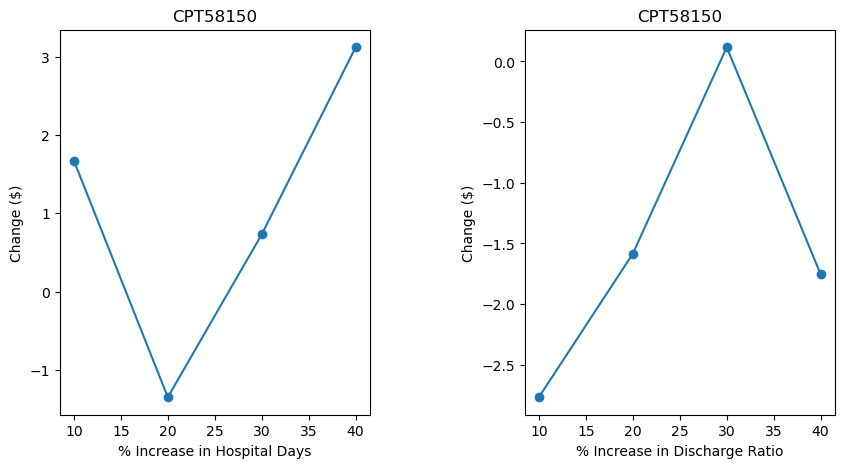

In [32]:
perc_change = [perc*100 for perc in deltas] #1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(perc_change, hosp_days_increase, 'o-')
ax[0].set(xlabel='% Increase in Hospital Days', ylabel='Change ($)', title=procedure)
ax[1].plot(perc_change, discharge_ratio_increase, 'o-')
ax[1].set(xlabel='% Increase in Discharge Ratio', ylabel='Change ($)', title=procedure);

This does not look promising, nor something that the hospital can control easily. This might be an option to avoid.

### 7.9.3 Scenario 3<a id='7.9.3_Scenario_3'></a>

In this scenario, we can increase the number of interns that the hospital recruits from the CMS.

In [33]:
intern_increase = [predict_increase(['Number of Interns and Residents (FTE)'], [delta]) for delta in deltas]

In [34]:
for p,delta in enumerate(deltas):
    print(f'This scenario increases discharge ratio by {delta*100:.0f} % for procedure price by ${intern_increase[p]:.2f}')

This scenario increases discharge ratio by 10 % for procedure price by $-0.04
This scenario increases discharge ratio by 20 % for procedure price by $1.13
This scenario increases discharge ratio by 30 % for procedure price by $1.13
This scenario increases discharge ratio by 40 % for procedure price by $1.13


We would need to increase our interns by 10-20% to see an increase. This seems feasible.

### 7.9.4 Scenario 4<a id='7.9.4_Scenario_4'></a>

In [35]:
price_deltas_combo = [predict_increase(['PSI_15','HAI_2_SIR'], [delta, delta]) for delta in deltas]

In [36]:
for p,delta in enumerate(deltas):
    print(f'This scenario increases both PSI 15 and HAI 2 SIR by {delta*100:.0f} % for procedure price by ${price_deltas_combo[p]:.2f}')

This scenario increases both PSI 15 and HAI 2 SIR by 10 % for procedure price by $-2.18
This scenario increases both PSI 15 and HAI 2 SIR by 20 % for procedure price by $0.87
This scenario increases both PSI 15 and HAI 2 SIR by 30 % for procedure price by $3.65
This scenario increases both PSI 15 and HAI 2 SIR by 40 % for procedure price by $11.96


## 7.10 Summary<a id='7.10_Summary'></a>

Using the model created from the prior notebook, predictions were made about price for CPT 58150 (under anesthesia hysterectomy procedure) for our random Florida hospital.
First, a prediction using the current features using this model resulted in a price of $1249.75, actual price is $1205.16. According to this model, we have room for a price increase. However the MAE falls within the actual price range.

Taking a step back, we explored features of our random hospital and compared them to other resorts, particularly for the features selected by our random forest model. We tend to be slightly above the mode or near the mode on most features compared to other hospitals. 

The potential scenarios we explored:
1. Increasing PSI 15 by a certain percentage or increase HAI 2 SIR by a certain percentage
2. Increase Demand by certain percentage by acquiring another hospital, either through discharge ratio/hospital days
3. Increase Number of Interns/Residents
4. Increase both PSI 15 and HAI 2 by a certain percentage

We accounted for each of these scenarios to determine the new price to be charged:

**For scenario 1:** The model supported this outcome, though only major increases in one or the other would need to be implemented.

**For scenario 2:** The model did not support this outcome and it would be extremely costly.

**For scenario 3:** This supported a slight increase by increasing interns greater than 20%.

**For scenario 4:** The model supported this outcome, especially if increasing both metrics by +30% or more.

Scenario 4 seems the most appealing to me. Increasing PSI and HAI go hand in hand and hospitals would be required to implement similar measures to increase both. In addition, we did not account for increases in other PSI values, or HAI values, which would probably increase as well with any hospital implementation of these metrics. 

## 7.11 Further work<a id='7.11_Further_work'></a>

There were certain limitations to the work done. First, looking at the data, I was not able to parse all the values from the JSON files just due to processing power. We were limited in areas where these prices came from, mostly from the state of Florida. In addition, we limited the procedures to look at. The datasets were matched on different time periods given the limitations of this analysis.

Additionally, our model did not have great accuracy, at around 79%. I believe a deeper model might be able to predict the prices at a better rate. Our predictions on how prices affect revenue limits our analysis on what decision is best. But this does show proof of concept.

This model could be used by our client for other parameter changes and we could set-up a new Jupyter notebook where one could set the parameters in one cell for other procedures.